In [23]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from scipy.stats import gaussian_kde
import shelve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [18]:
def shelf_read(filename):

    my_shelf = shelve.open(filename)
    for key in my_shelf:
        print(key)
        globals()[key]=my_shelf[key]
    my_shelf.close()
    
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = ax
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='black')
    
def RMSE_KFold(model, X, y, fit_params):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, fit_params=fit_params)
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    return np.mean(scores), np.std(scores)
    
def RF_grid(X, y, ofp):
    #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    print('Fitting models...')
    #n_estimators = X.shape[1]*10 # 10 times of number of predictors 
    #max_depth = None

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    
    best_random = rf_random.best_estimator_
    y_pred   = best_random.predict(X_test)
    model_RF = best_random
    
    print('Saving data...')
    filename = ofp + '_RF.out'
    my_shelf = shelve.open(filename, 'n')
    my_shelf['rf_random']     = rf_random
    my_shelf['model_RF']      = model_RF
    my_shelf['y_pred']        = y_pred 
    my_shelf['y_test']        = y_test
    my_shelf.close()

    print('Done')
    return y_pred, y_test

def RF(X, y, ofp):
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    print('Fitting models...')
    n_estimators = X.shape[1]*10 # 10 times of number of predictors 
    max_depth = None

    model_RF = RandomForestRegressor(n_estimators = n_estimators, 
                                     min_samples_split=2,
                                     bootstrap=2,
                                     criterion='mse',
                                     random_state=42,
                                     n_jobs=-1,
                                     max_depth=max_depth)
    
    print('Calculating RMSE...')
    fit_params={#'early_stopping_rounds': 10000,
                #'eval_metric': 'mae',
                #'verbose': False
               }
    
    RMSE, RMSE_std = RMSE_KFold(model_RF, X, y, fit_params)
    
    print('Predicting y_pred...')
    model_RF.fit(X_train, y_train)
    y_pred_RF = model_RF.predict(X_test)
    all_pred = y_pred_RF
    
    # final model; training model with all available data 
    model_RF.fit(X, y)
    
    print('Saving data...')
    filename = ofp + '_RF.out'
    my_shelf = shelve.open(filename, 'n')
    my_shelf['model_RF']      = model_RF
    my_shelf['RMSE']          = RMSE 
    my_shelf['RMSE_std']      = RMSE_std
    my_shelf['all_pred']      = all_pred
    my_shelf['y_test']        = y_test
    my_shelf.close()
    
    print('Done')

In [3]:
pr_file   = "/home/hyung/Lab/data/DL_Error/predictors.csv"
res_file  = "/home/hyung/Lab/data/DL_Error/responses.csv"
pr_data   = pd.read_csv(pr_file)
res_data  = pd.read_csv(res_file)

# Rainf_f/Precip/SWdown_min have some issue because they are all zeros
pr_data.drop(columns=['Rainf_min', 'Rainf_f_min', 'Rainf_f_max','Rainf_f_tavg', 'TotalPrecip_min'], inplace=True)
pr_data.drop(columns=['Evap_min', 'Evap_max', 'Evap_tavg'], inplace=True)
pr_data.drop(columns=['LWdown_f_max', 'LWdown_f_min', 'LWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['Qair_f_max',	'Qair_f_min', 'Qh_max',	'Qh_min'], inplace=True)
pr_data.drop(columns=['Qle_min', 'Qle_max', 'Qle_tavg'], inplace=True)
pr_data.drop(columns=['SWdown_f_min', 'SWdown_f_max', 'SWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['SMOS_RFI_min', 'SoilMoist_max', 'SoilMoist_min',	'SoilMoist_tavg'], inplace=True)
pr_data.drop(columns=['Tair_f_max', 'Tair_f_min', 'Tair_f_tavg', 'aspect'], inplace=True)
pr_data.drop(columns=['Wind_f_max',	'Wind_f_min', 'Wind_f_tavg'], inplace=True)
pr_data.drop(columns=['LAI_min', 'LAI_max','Greenness_min', 'Greenness_max', 'AvgSurfT_min', 'AvgSurfT_max'],inplace=True)
pr_data.drop(columns=['SoilTemp_min', 'SoilTemp_max','RadT_min', 'RadT_max'],inplace=True)
pr_data.drop(columns=['SMAP_vo_min', 'SMAP_vo_max','SMAP_rc_min', 'SMAP_rc_max'],inplace=True)
pr_data.drop(columns=['albedo_max', 'albedo_min','albedo_std', 'TotalPrecip_max','Rainf_max','SMOS_RFI_max'],inplace=True)

#Group the data using RFI values
nog = 10
RFI_tavg = pr_data['SMOS_RFI_tavg'].dropna(axis=0, how='any')
RFI_p = np.empty(nog, dtype=object)
for i in range(1,nog+1):
    RFI_p[i-1] = np.percentile(RFI_tavg, i*100/nog)

RFI_class = np.copy(pr_data['SMOS_RFI_tavg'])

for i in range(0,nog):
    if i > 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] > RFI_p[i-1]) & (pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
    elif i == 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
pr_data['RFI_class'] = RFI_class

# TC estimations with std value larger than 0.2 might be unstable
std_thred     = 0.1
mask_std_A2   = (res_data['AMSR2_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_AS   = (res_data['ASCAT_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMOS = (res_data['SMOS_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMAP = (res_data['SMAP_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)

# 2 clean the data sets
selected_predictors = list(pr_data.columns.values)

sel_A2   = selected_predictors.copy()
sel_A2.append('AMSR2_fMSE')
sel_AS   = selected_predictors.copy()
sel_AS.append('ASCAT_fMSE')
sel_SMOS = selected_predictors.copy()
sel_SMOS.append('SMOS_fMSE')
sel_SMAP = selected_predictors.copy()
sel_SMAP.append('SMAP_fMSE')

A2_fMSE   = pr_data.join(res_data['AMSR2_fMSE'])[sel_A2]
AS_fMSE   = pr_data.join(res_data['ASCAT_fMSE'])[sel_AS]
SMOS_fMSE = pr_data.join(res_data['SMOS_fMSE'])[sel_SMOS]
SMAP_fMSE = pr_data.join(res_data['SMAP_fMSE'])[sel_SMAP]

# select fMSE <= threshold
A2_fMSE   = A2_fMSE[mask_std_A2]
AS_fMSE   = AS_fMSE[mask_std_AS]
SMOS_fMSE = SMOS_fMSE[mask_std_SMOS]
SMAP_fMSE = SMAP_fMSE[mask_std_SMAP]
                      
# drop N/A
A2_fMSE.dropna(axis=0, how='any', inplace=True)
AS_fMSE.dropna(axis=0, how='any', inplace=True)
SMOS_fMSE.dropna(axis=0, how='any', inplace=True)
SMAP_fMSE.dropna(axis=0, how='any', inplace=True)

# Numeric, categorical predictors and response, y`
# AMSR2
A2_num   = A2_fMSE.drop(columns=['ltype', 'RFI_class', 'AMSR2_fMSE'])
A2_cat   = A2_fMSE['ltype']
A2_RFI   = A2_fMSE['RFI_class']
A2_y     = A2_fMSE['AMSR2_fMSE']
# ASCAT
AS_num   = AS_fMSE.drop(columns=['ltype', 'RFI_class', 'ASCAT_fMSE'])
AS_cat   = AS_fMSE['ltype']
AS_RFI   = AS_fMSE['RFI_class']
AS_y     = AS_fMSE['ASCAT_fMSE']
# SMOS
SMOS_num = SMOS_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_fMSE'])
SMOS_cat = SMOS_fMSE['ltype']
SMOS_RFI = SMOS_fMSE['RFI_class']
SMOS_y   = SMOS_fMSE['SMOS_fMSE']
# SMAP
SMAP_num = SMAP_fMSE.drop(columns=['ltype', 'RFI_class', 'SMAP_fMSE'])
SMAP_cat = SMAP_fMSE['ltype']
SMAP_RFI = SMAP_fMSE['RFI_class']
SMAP_y   = SMAP_fMSE['SMAP_fMSE']

all_predictors = SMAP_num.columns.values

# Standardize numeric/response columns, to mean 0 variance 1
# AMSR2
A2_mean       = A2_num.mean()
A2_std        = A2_num.std()
A2_num_scaled = np.array((A2_num - A2_mean) / A2_std)
A2_y_mean     = A2_y.mean()
A2_y_std      = A2_y.std()
A2_y_scaled   = np.array((A2_y - A2_y_mean) / A2_y_std)
# ASCAT
AS_mean       = AS_num.mean()
AS_std        = AS_num.std()
AS_num_scaled = np.array((AS_num - AS_mean) / AS_std)
AS_y_mean     = AS_y.mean()
AS_y_std      = AS_y.std()
AS_y_scaled   = np.array((AS_y - AS_y_mean) / AS_y_std)
# SMOS
SMOS_mean       = SMOS_num.mean()
SMOS_std        = SMOS_num.std()
SMOS_num_scaled = np.array((SMOS_num - SMOS_mean) / SMOS_std)
SMOS_y_mean     = SMOS_y.mean()
SMOS_y_std      = SMOS_y.std()
SMOS_y_scaled   = np.array((SMOS_y - SMOS_y_mean) / SMOS_y_std)
# SMAP
SMAP_mean        = SMAP_num.mean()
SMAP_std         = SMAP_num.std()
SMAP_num_scaled  = np.array((SMAP_num - SMAP_mean) / SMAP_std)
SMAP_y_mean      = SMAP_y.mean()
SMAP_y_std       = SMAP_y.std()
SMAP_y_scaled    = np.array((SMAP_y - SMAP_y_mean) / SMAP_y_std)

In [21]:
# Previously, I used RF(args). But I updated it to RF_grid function to gridsearchCV
product_list = ['SMAP', 'SMOS', 'AS', 'A2']

for i in range(0,4):
    product = product_list[i]
    print(product)
    exec('X = '+product+'_num_scaled')
    exec('y = '+product+'_y')
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    RF_grid(X,y, ofp)

SMAP
Fitting models...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 496 out of 500 | elapsed: 22.6min remaining:   10.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.9min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Saving data...
SMOS
Fitting models...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 496 out of 500 | elapsed: 20.2min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 20.4min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Saving data...
AS
Fitting models...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 496 out of 500 | elapsed: 19.5min remaining:    9.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.8min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Saving data...
A2
Fitting models...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 496 out of 500 | elapsed: 19.1min remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.5min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Saving data...


SMAP
rf_random
model_RF
y_pred
y_test
SMOS
rf_random
model_RF
y_pred
y_test
AS
rf_random
model_RF
y_pred
y_test
A2
rf_random
model_RF
y_pred
y_test


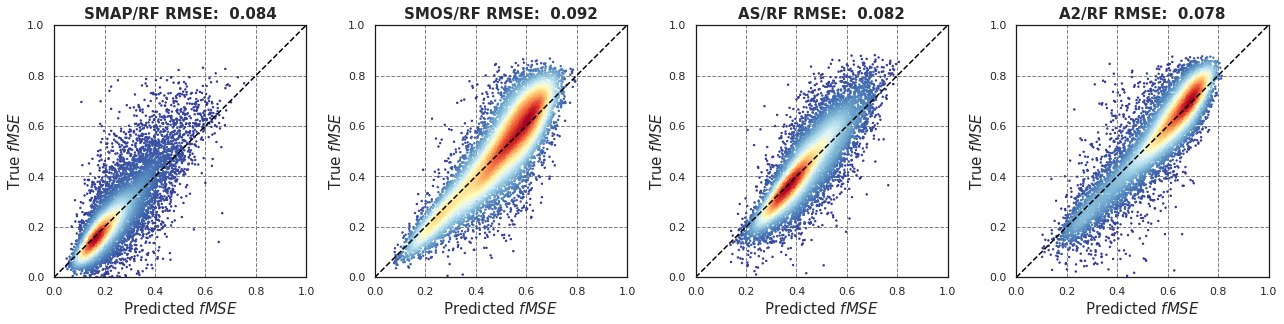

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(18,18)
model_list = ['SMAP', 'SMOS', 'ASCAT', 'ASMR2']
for i in range(0,4):
    product = product_list[i]
    print(product)
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    shelf_read(ofp+'_RF.out')

    xy = np.vstack([y_pred, y_test])
    z = gaussian_kde(xy)(xy)
    
    ax = ax.flatten()
    ax[i].scatter(y_pred, y_test, c=z, s=2, cmap='RdYlBu_r')
    #plt.scatter(1,1)
    ax[i].set_xlabel('Predicted $\it{fMSE}$', size=15)
    ax[i].set_ylabel("True $\it{fMSE}$", size=15)

    ax[i].set_xticks(np.arange(0,1.2,0.2))
    ax[i].set_yticks(np.arange(0,1.2,0.2))
    plt.setp(ax[i].spines.values(), color='k')
    ax[i].grid(b=True, which='major', color='grey', linestyle='--')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,1)
    ax[i].set_facecolor("white")
    ax[i].set_aspect('equal')
    RMSE = mean_squared_error(y_test, y_pred, squared=False) 
    ax[i].set_title(product+'/RF'+f' RMSE: {RMSE: .3f}', size=15, fontweight='bold')
    abline(1,0, ax[i])
fig.tight_layout()
plt.show()

SMAP
rf_random
model_RF
y_pred
y_test


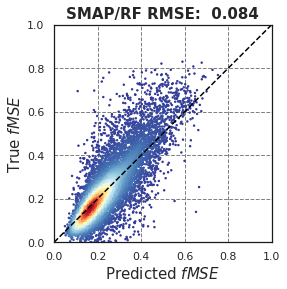

In [28]:
product_list = ['SMAP', 'SMOS', 'AS', 'A2']
product = product_list[0]
print(product)
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
shelf_read(ofp+'_RF.out')

fig, ax = plt.subplots()
xy = np.vstack([y_pred, y_test])
z = gaussian_kde(xy)(xy)
#i=0
#ax = ax.flatten()
ax.scatter(y_pred, y_test, c=z, s=2, cmap='RdYlBu_r')
#plt.scatter(1,1)
ax.set_xlabel('Predicted $\it{fMSE}$', size=15)
ax.set_ylabel("True $\it{fMSE}$", size=15)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
plt.setp(ax.spines.values(), color='k')
ax.grid(b=True, which='major', color='grey', linestyle='--')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_facecolor("white")
ax.set_aspect('equal')
RMSE = mean_squared_error(y_test, y_pred, squared=False) 
ax.set_title(product+'/RF'+f' RMSE: {RMSE: .3f}', size=15, fontweight='bold')
abline(1,0, ax)

In [86]:
# RF(args) does not do gridsearch. This is old code.
product_list = ['SMAP', 'SMOS', 'AS', 'A2']

for i in range(0,4):
    product = product_list[i]
    print(product)
    exec('X = '+product+'_num_scaled')
    exec('y = '+product+'_y')
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    RF(X,y, ofp)

SMAP
Fitting models...
Calculating RMSE...
Mean RMSE: 0.085 (0.002)
Predicting y_pred...
Saving data...
Done
SMOS
Fitting models...
Calculating RMSE...
Mean RMSE: 0.093 (0.001)
Predicting y_pred...
Saving data...
Done
AS
Fitting models...
Calculating RMSE...
Mean RMSE: 0.083 (0.002)
Predicting y_pred...
Saving data...
Done
A2
Fitting models...
Calculating RMSE...
Mean RMSE: 0.079 (0.002)
Predicting y_pred...
Saving data...
Done
